In [1]:
import phreeqcrm
import numpy as np
import matplotlib.pyplot as plt

Create yaml for initialize()

In [2]:
# Create YAMLPhreeqcRM document
yrm = phreeqcrm.YAMLPhreeqcRM()

# Number of cells
nxyz = 40

# Set GridCellCount
yrm.YAMLSetGridCellCount(nxyz)

# Set some properties
yrm.YAMLSetErrorHandlerMode(1)
yrm.YAMLSetComponentH2O(False)
yrm.YAMLSetRebalanceFraction(0.5)
yrm.YAMLSetRebalanceByCell(True)
yrm.YAMLUseSolutionDensityVolume(False)
yrm.YAMLSetPartitionUZSolids(False)

# Set concentration units
yrm.YAMLSetUnitsSolution(2)           # 1, mg/L; 2, mol/L; 3, kg/kgs
yrm.YAMLSetUnitsPPassemblage(1)       # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsExchange(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsSurface(1)            # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsGasPhase(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsSSassemblage(1)       # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsKinetics(1)           # 0, mol/L cell; 1, mol/L water; 2 mol/L rock

# Set conversion from seconds to user units (days) Only affects one print statement
time_conversion = 1.0 / 86400.0
yrm.YAMLSetTimeConversion(time_conversion)

# Set representative volume
rv = [1] * nxyz
yrm.YAMLSetRepresentativeVolume(rv)

# Set initial density
density = [1.0] * nxyz
yrm.YAMLSetDensityUser(density)

# Set initial porosity
por = [0.2] * nxyz
yrm.YAMLSetPorosity(por)

# Set initial saturation
sat = [1] * nxyz
yrm.YAMLSetSaturationUser(sat)

# Load database
yrm.YAMLLoadDatabase("phreeqc.dat")

# Run file to define solutions and reactants for initial conditions, selected output
workers = True             # Worker instances do the reaction calculations for transport
initial_phreeqc = True     # InitialPhreeqc instance accumulates initial and boundary conditions
utility = True             # Utility instance is available for processing
yrm.YAMLRunFile(workers, initial_phreeqc, utility, "advect.pqi")

# Clear contents of workers and utility
initial_phreeqc = False
input = "DELETE; -all"
yrm.YAMLRunString(workers, initial_phreeqc, utility, input)
yrm.YAMLAddOutputVars("AddOutputVars", "true")

# Determine number of components to transport
yrm.YAMLFindComponents()

# initial solutions
initial_solutions = [1] * nxyz
yrm.YAMLInitialSolutions2Module(initial_solutions)

# initial exchanges
initial_exchanges = [1] * nxyz
yrm.YAMLInitialExchanges2Module(initial_exchanges)

# Write YAML file
yrm.WriteYAMLDoc("ex11-advect.yaml")


Define function to perform advection of cells

In [3]:
def advect(c: np.ndarray, bc_conc: np.ndarray, ncomps: int, nxyz: int):
    # Advect
    for i in range(nxyz - 1, 0, -1):
        for j in range(ncomps):
            c[j * nxyz + i] = c[j * nxyz + i - 1]              # component j
    
    # Cell zero gets boundary condition
    for j in range(ncomps):
        c[j * nxyz] = bc_conc[j]                               # component j

Transient loop

In [4]:
rm = phreeqcrm.BMIPhreeqcRM()
rm.initialize("ex11-advect.yaml")

ncomps = rm.get_value_ptr("ComponentCount")[0]
assert nxyz == rm.get_value_ptr("GridCellCount")[0]

# Get initial concentrations
c = rm.get_value_ptr("Concentrations")

# --------------------------------------------------------------------------
# Set boundary condition
# --------------------------------------------------------------------------
bc1 = [0]           # solution 0 from Initial IPhreeqc instance

bc_conc = rm.InitialPhreeqc2Concentrations(bc1)

solution_total_molality_Cl = np.empty((nxyz,), dtype=float)
solution_total_molality_Na = np.empty((nxyz,), dtype=float)
solution_total_molality_K  = np.empty((nxyz,), dtype=float)
solution_total_molality_Ca = np.empty((nxyz,), dtype=float)

nsteps = 100
Na = np.empty((nsteps,), dtype=float)
Cl = np.empty((nsteps,), dtype=float)
K = np.empty((nsteps,), dtype=float)
Ca = np.empty((nsteps,), dtype=float)

por_volumes = np.empty((nsteps,), dtype=float)

print(f"step Na Cl K Ca Pore_vol")
for s in range(nsteps):
    rm.update()

    advect(c, bc_conc, ncomps, nxyz)
    rm.set_value("Concentrations", c)

    solution_total_molality_Cl = rm.get_value("solution_total_molality_Cl", solution_total_molality_Cl)
    solution_total_molality_Na = rm.get_value("solution_total_molality_Na", solution_total_molality_Na)
    solution_total_molality_K  = rm.get_value("solution_total_molality_K",  solution_total_molality_K)
    solution_total_molality_Ca = rm.get_value("solution_total_molality_Ca", solution_total_molality_Ca)

    cell = nxyz - 1
    step = s + 1
    por_vol = (step + 0.5) / 40

    Na[s] = solution_total_molality_Na[cell]
    Cl[s] = solution_total_molality_Cl[cell]
    K[s]  = solution_total_molality_K[cell]
    Ca[s] = solution_total_molality_Ca[cell]
    por_volumes[s] = por_vol
    print(f"{step} {Na[s]:.4e} {Cl[s]:.4e} {K[s]:.4e} {Ca[s]:.4e} {por_volumes[s]:.4e}")

step Na Cl K Ca Pore_vol
1 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 3.7500e-02
2 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 6.2500e-02
3 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 8.7500e-02
4 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 1.1250e-01
5 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 1.3750e-01
6 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 1.6250e-01
7 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 1.8750e-01
8 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 2.1250e-01
9 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 2.3750e-01
10 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 2.6250e-01
11 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 2.8750e-01
12 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 3.1250e-01
13 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 3.3750e-01
14 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 3.6250e-01
15 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 3.8750e-01
16 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 4.1250e-01
17 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 4.3750e-0

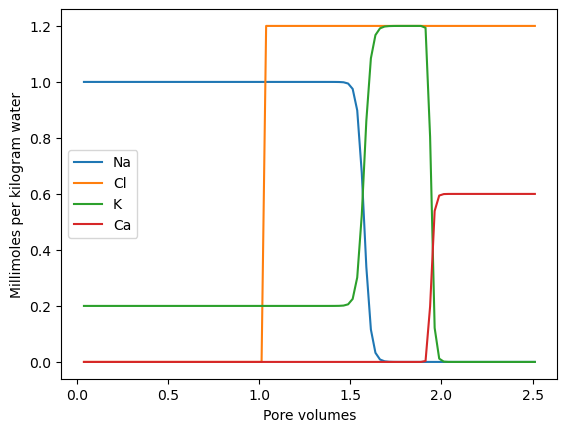

In [5]:
fig, ax = plt.subplots()
ax.plot(por_volumes, Na*1000, label='Na')
ax.plot(por_volumes, Cl*1000, label='Cl')
ax.plot(por_volumes, K*1000,  label='K')
ax.plot(por_volumes, Ca*1000, label='Ca')
ax.set_xlabel('Pore volumes')
ax.set_ylabel('Millimoles per kilogram water')
ax.legend()
plt.show()